Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3733.517, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3745.309, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3738.774, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3732.609, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3744.212, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3734.083, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3734.286, Time=0.27 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3734.394, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3732.849, Time=0.10 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3736.285, Time=0.62 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3743.536, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3731.961, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3734.111, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3733.410, Time=0.37 sec
 ARIMA(1,1,1)(0,0,2

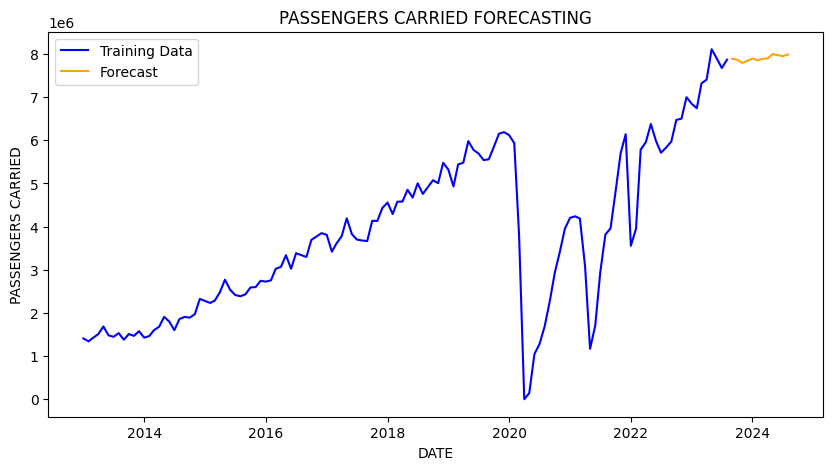

Importing plotly failed. Interactive plots will not work.
21:27:32 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Kishan teja\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


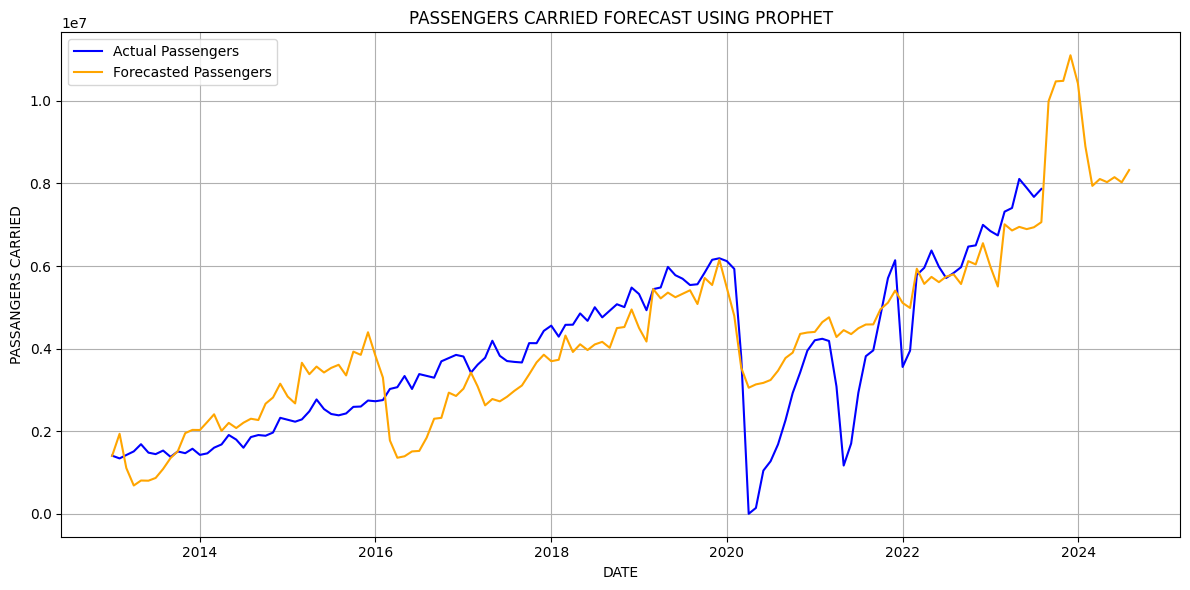

In [2]:
# Part(a)
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = pd.read_csv("AirtrafficA4.csv")
data.columns = data.columns.str.strip()
data['MONTH'] = data['MONTH'].str.strip()
# print(data['MONTH'])

# columns in AirtrafficA4
Columns = ["TOTAL DEPARTURES", "HOURS FLOWN", "KILOMETRE FLOWN", 
                "PASSENGERS CARRIED", "AVAILABLE SEAT KILOMETRE (IN THOUSAND)", 
                "FREIGHT CARRIED (IN TONNE)", "MAIL CARRIED (IN TONNE)"]

for col in Columns:
    data[col] = pd.to_numeric(data[col].replace({",": ""}, regex=True), errors='coerce')
# replace missing values with 0
data.fillna(0, inplace=True)

# making month mapping
MonthMapping = {
    'JAN': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'APR': 'Apr', 'MAY': 'May', 
    'JUN': 'Jun', 'JUL': 'Jul', 'AUG': 'Aug', 'SEP': 'Sep', 
    'OCT': 'Oct', 'NOV': 'Nov', 'DEC': 'Dec', 'JUNE': 'Jun', 'JULY': 'Jul'
}
data['MONTH'] = data['MONTH'].str[:3].str.upper().map(MonthMapping)

# Converting 'YEAR' and 'MONTH' to a single datetime column
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + "-" + data['MONTH'], format="%Y-%b")
data.set_index('DATE', inplace=True)

# Convert the index to PeriodIndex
data.index = data.index.to_period("M")
data = data.sort_index()
# print(data.index)

# Selecting the 'PASSENGERS CARRIED' column
npassengers = data['PASSENGERS CARRIED']

# training data
ntraining = npassengers.loc[:'2023-08']

model = auto_arima(ntraining,seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True,max_p=4,max_d=4,max_q=3,max_P=4,max_D=2,max_Q=4)
# print(model.summary())

sarima_model = SARIMAX(ntraining,order=model.order, seasonal_order=model.seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the next 12 months
nforecasted = 12
forecast = sarima_result.get_forecast(steps=nforecasted)
ForecastedValues = forecast.predicted_mean
# print(ForecastedValues)

ForecastDF = pd.DataFrame({
    'YEAR_MONTH': ForecastedValues.index.strftime('%Y %b').str.upper(),
    'PASSENGERS CARRIED': ForecastedValues.values.astype(int)
})
ForecastDF['YEAR_MONTH'] = '"' + ForecastDF['YEAR_MONTH'] + '"'

# Writing the forecast to a CSV file
with open('passengers_forecast.csv', 'w', newline='') as file:
    file.write('YEAR_MONTH,PASSENGERS CARRIED\n')
    for index, row in ForecastDF.iterrows():
        file.write(f"{row['YEAR_MONTH']},{row['PASSENGERS CARRIED']}\n")

fIndex = ForecastedValues.index
# indeces for plotting
fIndex = ForecastedValues.index.to_timestamp()
TrainingIndex = ntraining.index.to_timestamp()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(TrainingIndex, ntraining, label='Training Data', color='blue')
plt.plot(fIndex, ForecastedValues, label='Forecast', color='orange')
plt.title('PASSENGERS CARRIED FORECASTING')
plt.xlabel('DATE')
plt.ylabel('PASSENGERS CARRIED')
plt.legend()
plt.savefig('Q2a.png')
plt.show()

# Part(c)
# importing moduels
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Loading AirtrafficA4
data = pd.read_csv("AirtrafficA4.csv")
data.columns = data.columns.str.strip()

# Column in AirtrafficA4
data['MONTH'] = data['MONTH'].str.strip()
numeric_cols = ["TOTAL DEPARTURES", "HOURS FLOWN", "KILOMETRE FLOWN", "PASSENGERS CARRIED", "AVAILABLE SEAT KILOMETRE (IN THOUSAND)", "FREIGHT CARRIED (IN TONNE)", "MAIL CARRIED (IN TONNE)"]

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col].replace({",": ""}, regex=True), errors='coerce')
data.fillna(0, inplace=True)

month_mapping = {'JAN': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'APR': 'Apr', 'MAY': 'May', 'JUN': 'Jun', 'JUL': 'Jul', 'AUG': 'Aug', 'SEP': 'Sep', 'OCT': 'Oct', 'NOV': 'Nov', 'DEC': 'Dec', 'JUNE': 'Jun', 'JULY': 'Jul'}
data['MONTH'] = data['MONTH'].str[:3].str.upper().map(month_mapping)

# Converting 'YEAR' and 'MONTH' to a single datetime column
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + "-" + data['MONTH'], format="%Y-%b")
data.set_index('DATE', inplace=True)
data = data.sort_index()

# Preparing data for Prophet
passenger_series = data[['PASSENGERS CARRIED']].copy()
passenger_series = passenger_series.rename_axis('ds').reset_index()
passenger_series = passenger_series.rename(columns={'ds': 'ds', 'PASSENGERS CARRIED': 'y'})

# Initializing and fitting the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.44, fourier_order=5)  # Approx. number of days in a month
model.fit(passenger_series)
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

forecast_values = forecast[['ds', 'yhat']].tail(12)

# Plotting the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(passenger_series['ds'], passenger_series['y'], label='Actual Passengers', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Passengers', color='orange')
plt.title('PASSENGERS CARRIED FORECAST USING PROPHET')
plt.xlabel('DATE')
plt.ylabel('PASSANGERS CARRIED')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('Q2c.png')
plt.show()